# **Home Assignment – Clustering Firewall Objects**

### Stav Nimrod

The purpose of this assignment is to evaluate your ability to process and analyze network connection data by generating a dataset of 5-tuple connections and then clustering them based on their characteristics (source IP, source port, protocol, destination IP, and destination port).

The goal is to group similar network connections, which can be useful in identifying patterns such as potential attacks, load-balancing behaviors, or common traffic patterns.

The task will also require you to implement a clustering scale, where the tightness or looseness of clustering can be controlled by a parameter.

## **Synthetic Dataset**

Assumptions:
1. there are 2 private networks
2. small private network has 50 devices 10.0.0.[1,50]
3. big private network has 100 devices 192.168.0.[1,100]
4. ~30% of records are within small private network
5. ~50% of records are within big private network
6. ~10% of records are between the 2 private networks
7. ~10% of records are between outside source to a private network
8. ~80% of the records are TCP and ~20% are UDP
9. ~80% of the records has common ports and ~20% has ports from [1,65535]
10. if the protocol is TCP, there is 95% chance of adding the same packet with reversed direction
11. if the protocol is UDP, there is 1% chance of adding the same packet with reversed direction

In [1]:
import pandas as pd
import numpy as np
import random
import ipaddress
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Constants
N = 100000  # Number of unique network connection records
SMALL_NET_DEVICES = 50
BIG_NET_DEVICES = 100
COMMON_PORT_PROB = 0.8
PORT_MIN = 1
PORT_MAX = 65535
COMMON_PORTS = [80, 443, 53, 22, 25]
# Common ports:
# 80  - HTTP: Unsecured web traffic, widely used for browsing websites.
# 443 - HTTPS: Secure web traffic, used for encrypted communication over the web.
# 53  - DNS: Domain Name System traffic, used for resolving domain names to IP addresses.
# 22  - SSH: Secure Shell, used for secure remote login and other secure network services.
# 25  - SMTP: Simple Mail Transfer Protocol, used for sending emails.

# Generate IPs for small and big private networks
small_net_ips = [f"10.0.0.{i}" for i in range(1, SMALL_NET_DEVICES + 1)]
big_net_ips = [f"192.168.0.{i}" for i in range(1, BIG_NET_DEVICES + 1)]

# Record Distribution
within_small_net_prob = 0.3
within_big_net_prob = 0.5
between_private_nets_prob = 0.1
outside_to_private_prob = 0.1

# Protocol Distribution
tcp_prob = 0.8
udp_prob = 0.2

# Generate a random public IP address (excluding private ranges)
def random_ip():
    while True:
        ip = ipaddress.IPv4Address(random.randint(0, (2**32)-1))
        if not ip.is_private:  # Exclude private IPs
            return str(ip)

# Function to randomly assign common or uncommon ports
def assign_port():
    if random.random() < COMMON_PORT_PROB:
        return random.choice(COMMON_PORTS)
    else:
        return random.randint(PORT_MIN, PORT_MAX)

# Function to randomly assign protocol based on probability
def assign_protocol():
    return "TCP" if random.random() < tcp_prob else "UDP"

In [3]:
# Generate 100,000 unique records
record_set = set()
random.seed(42)

while len(record_set) < N:
    rand_val = random.random()

    if rand_val < within_small_net_prob:
        # Within small private network
        src_ip = random.choice(small_net_ips)
        dst_ip = random.choice(small_net_ips)
    elif rand_val < within_small_net_prob + within_big_net_prob:
        # Within big private network
        src_ip = random.choice(big_net_ips)
        dst_ip = random.choice(big_net_ips)
    elif rand_val < within_small_net_prob + within_big_net_prob + between_private_nets_prob:
        # Between big/small private network
        if random.random() < 0.5:
            # Small to big
            src_ip = random.choice(small_net_ips)
            dst_ip = random.choice(big_net_ips)
        else:
            # Big to small
            src_ip = random.choice(big_net_ips)
            dst_ip = random.choice(small_net_ips)
    else:
        # Between outside/private network
        if random.random() < 0.5:
            # Outside to private
            src_ip = random_ip()
            dst_ip = random.choice(small_net_ips + big_net_ips)
        else:
            # Private to outside
            src_ip = random.choice(small_net_ips + big_net_ips)
            dst_ip = random_ip()

    src_port = assign_port()
    dst_port = assign_port()
    protocol = assign_protocol()

    # Add record
    record_set.add((src_ip, src_port, protocol, dst_ip, dst_port))

    # Check if we should append the reversed record based on protocol
    if protocol == "TCP" and random.random() < 0.95:
        record_set.add((dst_ip, dst_port, protocol, src_ip, src_port))
    elif protocol == "UDP" and random.random() < 0.01:
        record_set.add((dst_ip, dst_port, protocol, src_ip, src_port))

# Convert the set of tuples to a DataFrame
df = pd.DataFrame(list(record_set), columns=["src_ip", "src_port", "protocol", "dst_ip", "dst_port"])

In [4]:
df

,src_ip,src_port,protocol,dst_ip,dst_port
0,192.168.0.51,62978,TCP,192.168.0.91,7335
1,10.0.0.49,53,TCP,192.168.0.89,22
2,192.168.0.87,53,TCP,10.0.0.35,40970
3,192.168.0.88,27857,TCP,192.168.0.34,13382
4,192.168.0.69,25930,UDP,192.168.0.59,53
...,...,...,...,...,...
99995,10.0.0.27,40164,TCP,10.0.0.42,443
99996,10.0.0.47,53,TCP,10.0.0.28,443
99997,36.155.205.133,58333,TCP,192.168.0.4,80
99998,192.168.0.11,53,TCP,192.168.0.38,80


## **Clustering**

In [5]:
SCALE_FACTOR = 2
SAMPLE_SIZE = 10000
df_sample = df.iloc[:SAMPLE_SIZE].copy()

In [6]:
def scale_to_clusters(scale_factor, num_records):
    if scale_factor == 0:
        return num_records  # Each record is its own cluster
    elif scale_factor == 5:
        return 1  # All records grouped into one cluster
    else:
        # Scale between these extremes
        max_clusters = num_records // 1000  # Arbitrary max cluster number
        return max(1, max_clusters // scale_factor)


# Determine number of clusters based on scale_factor
n_clusters = scale_to_clusters(SCALE_FACTOR, SAMPLE_SIZE)

#### Calculate connections distance matrix

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from ipaddress import ip_address

# Define network types based on IP address patterns
def network_type(ip):
    if ip.startswith('10.0.0.'):
        return 'small'
    elif ip.startswith('192.168.0.'):
        return 'big'
    else:
        return 'public'

# Convert IPs to integers using vectorization
def ip_to_int_vec(ips):
    return np.array([int(ip_address(ip)) for ip in ips])

# Function to calculate pairwise distances using NumPy vectorization
def calculate_pairwise_distances_vectorized(data):
    num_records = data.shape[0]

    # Convert IP addresses to integers
    src_ips_int = ip_to_int_vec(data['src_ip'])
    dst_ips_int = ip_to_int_vec(data['dst_ip'])

    # Normalize IP distances
    max_ip = 4294967295  # Max value for IPv4
    src_ip_diff = np.abs(src_ips_int[:, np.newaxis] - src_ips_int) / max_ip
    dst_ip_diff = np.abs(dst_ips_int[:, np.newaxis] - dst_ips_int) / max_ip

    # Normalize port differences
    max_port = 65535
    src_port_diff = np.abs(data['src_port'].values[:, np.newaxis] - data['src_port'].values) / max_port
    dst_port_diff = np.abs(data['dst_port'].values[:, np.newaxis] - data['dst_port'].values) / max_port

    # Protocol differences (0 if same, 1 if different)
    protocol_diff = np.where(data['protocol'].values[:, np.newaxis] == data['protocol'].values, 0, 1)

    # Vectorized calculation of network types (small, big, public)
    src_network_types = np.array([network_type(ip) for ip in data['src_ip']])
    dst_network_types = np.array([network_type(ip) for ip in data['dst_ip']])

    # Source and destination network type differences
    src_network_type_diff = np.where(src_network_types[:, np.newaxis] == src_network_types, 0, 1)
    dst_network_type_diff = np.where(dst_network_types[:, np.newaxis] == dst_network_types, 0, 1)

    # Same network type distance
    same_network_type_diff = np.where(src_network_type_diff == dst_network_type_diff, 0, 1)

    # Combine all distance components
    distances = (
        src_ip_diff + dst_ip_diff +
        src_port_diff + dst_port_diff +
        protocol_diff +
        # src_network_type_diff + dst_network_type_diff +
        same_network_type_diff * 3
    )

    return distances

# Compute the distance matrix using vectorization
dist_matrix = calculate_pairwise_distances_vectorized(df_sample)

#### **KMedoids**

In [8]:
!pip install scikit-learn-extra

In [9]:
from sklearn_extra.cluster import KMedoids

# Perform K-medoids clustering
kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', random_state=42).fit(dist_matrix)

# Assign clusters to the dataset
df_sample['kmedoids_cluster'] = kmedoids.labels_


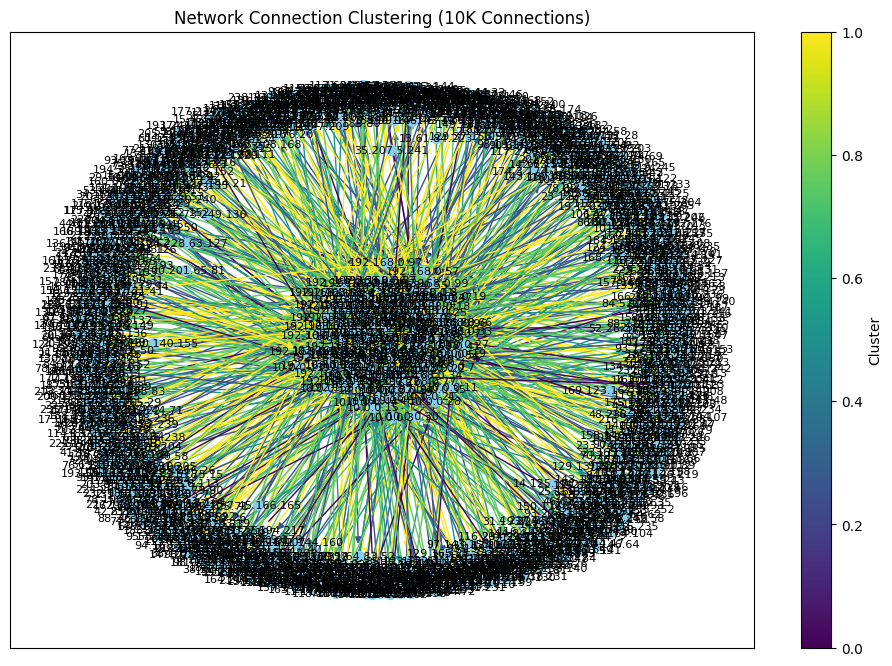

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for idx, row in df_sample.iterrows():
    src_ip = row['src_ip']
    dst_ip = row['dst_ip']
    protocol = row['protocol']
    src_port = row['src_port']
    dst_port = row['dst_port']
    cluster = row['kmedoids_cluster']

    # Add an edge from src_ip to dst_ip with the connection attributes
    G.add_edge(src_ip, dst_ip, protocol=protocol, src_port=src_port, dst_port=dst_port, cluster=cluster)

# Visualize the graph
plt.figure(figsize=(12, 8))

# Draw the graph, coloring the edges by the cluster
pos = nx.spring_layout(G, k=0.5)  # Position nodes using a force-directed layout
edge_colors = [d['cluster'] for (u, v, d) in G.edges(data=True)]  # Color by cluster

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue')

# Draw edges with color based on cluster
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.viridis, arrows=True)

# Add labels for nodes (IP addresses)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

plt.title('Network Connection Clustering (10K Connections)')
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='Cluster')
plt.show()


In [11]:
df_sample['kmedoids_cluster'].value_counts()

,count
kmedoids_cluster,
4,3113
0,2752
2,2529
3,819
1,787


Reduce the visualization to display 0.5% random connections of each cluster

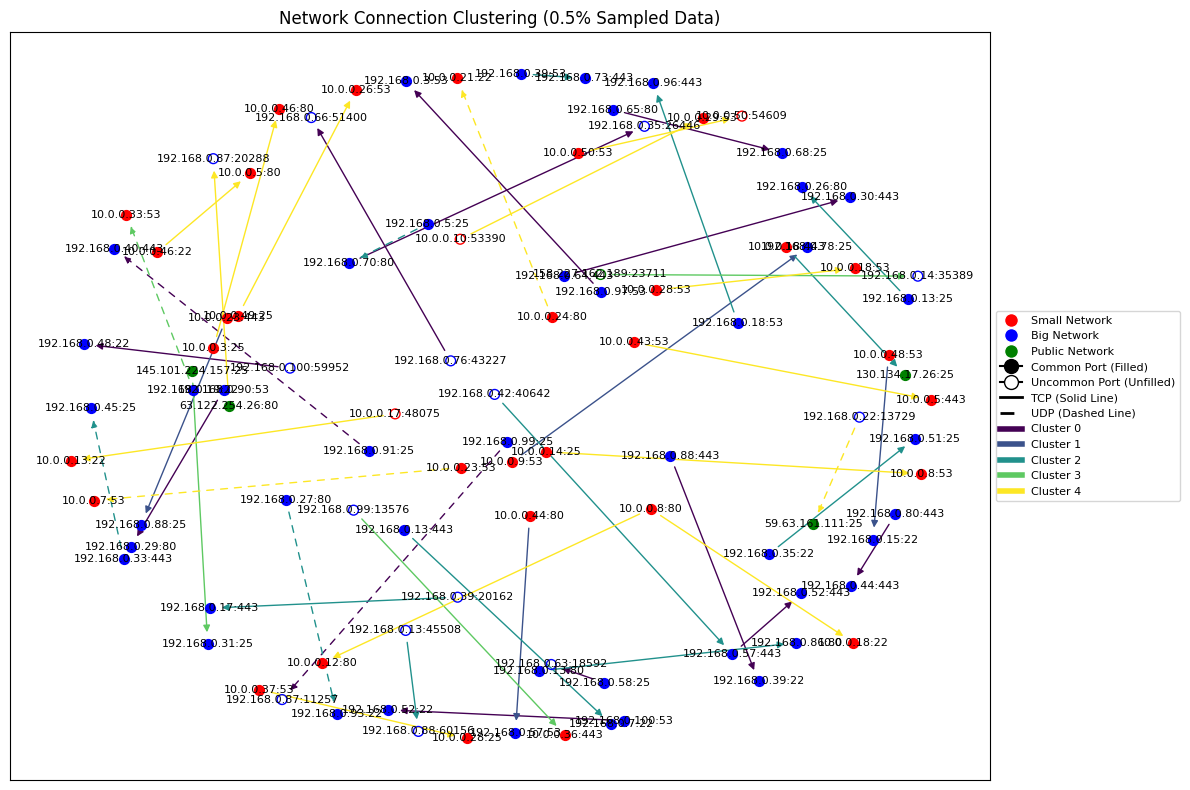

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Define network types based on IP address patterns
def network_type(ip):
    if ip.startswith('10.0.0.'):
        return 'small'
    elif ip.startswith('192.168.0.'):
        return 'big'
    else:
        return 'public'

# Define common ports
COMMON_PORTS = [80, 443, 53, 22, 25]

# Function to sample x% of each cluster
def sample_x_percent(data):
    return data.groupby('kmedoids_cluster', group_keys=False).apply(lambda x: x.sample(frac=0.005))

# Sample x% of data points from each cluster
df_sampled = sample_x_percent(df_sample)

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes and edges from the sampled data to the graph
for idx, row in df_sampled.iterrows():
    src_ip_port = f"{row['src_ip']}:{row['src_port']}"
    dst_ip_port = f"{row['dst_ip']}:{row['dst_port']}"
    protocol = row['protocol']
    cluster = row['kmedoids_cluster']

    # Add an edge from src_ip:src_port to dst_ip:dst_port with the connection attributes
    G.add_edge(src_ip_port, dst_ip_port, protocol=protocol, cluster=cluster)

# Get unique clusters
unique_clusters = df_sampled['kmedoids_cluster'].unique()

# Generate a discrete colormap for clusters using linspace and colormap
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(unique_clusters))]
cluster_to_color = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

# Define node colors based on network type
node_color_map = {
    'small': 'red',    # Small network nodes will be red
    'big': 'blue',     # Big network nodes will be blue
    'public': 'green'  # Public network nodes will be green
}

# Visualize the graph
plt.figure(figsize=(12, 8))

# Get positions of the nodes using a spring layout
pos = nx.spring_layout(G, k=0.5)  # Position nodes using a force-directed layout

# Draw edges with different styles based on the protocol
for edge in G.edges(data=True):
    src, dst = edge[0], edge[1]
    protocol = edge[2]['protocol']
    cluster = edge[2]['cluster']

    # Set the edge color based on the cluster
    edge_color = cluster_to_color[cluster]

    # Set the edge style based on the protocol
    if protocol == 'TCP':
        style = 'solid'  # Solid line for TCP
    else:
        style = (0, (5, 5))  # Dashed line for UDP

    # Draw the edge with the specified style and color
    nx.draw_networkx_edges(G, pos, edgelist=[(src, dst)], edge_color=edge_color, style=style)

# Draw nodes by color based on network type, and fill based on common ports
for node in G.nodes():
    ip, port = node.split(':')
    port = int(port)  # Convert port to integer
    n_type = network_type(ip)
    node_color = node_color_map[n_type]

    # Check if the port is common
    if port in COMMON_PORTS:
        # Common port: Filled node
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=50, node_color=node_color)
    else:
        # Uncommon port: Empty node (only border)
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=50, edgecolors=node_color, node_color='none')

# Add labels for nodes (IP:Port addresses)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

# Custom legend for nodes and edges

# Legend for network types
network_legend = [
    Line2D([0], [0], marker='o', color='w', label='Small Network', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Big Network', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Public Network', markerfacecolor='green', markersize=10)
]

# Legend for common vs uncommon ports (filled vs unfilled nodes)
port_legend = [
    Line2D([0], [0], marker='o', color='black', label='Common Port (Filled)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='black', label='Uncommon Port (Unfilled)', markerfacecolor='w', markersize=10)
]

# Legend for protocol (TCP vs UDP, line styles)
protocol_legend = [
    Line2D([0], [0], color='black', lw=2, label='TCP (Solid Line)', linestyle='solid'),
    Line2D([0], [0], color='black', lw=2, label='UDP (Dashed Line)', linestyle=(0, (5, 5)))
]

# Legend for cluster colors (edge colors)
cluster_legend = [
    Line2D([0], [0], color=colors[i], lw=4, label=f'Cluster {unique_clusters[i]}') for i in range(len(unique_clusters))
]

# Combine all legends
plt.legend(handles=network_legend + port_legend + protocol_legend + cluster_legend,
           loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

plt.title('Network Connection Clustering (0.5% Sampled Data)')
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


In [13]:
for c in unique_clusters:
  print('Cluster', c)
  print(df_sample[df_sample['kmedoids_cluster']==c].iloc[:, 0:4])
  print('\n'*5)

Cluster 0
            src_ip  src_port protocol        dst_ip
0     192.168.0.51     62978      TCP  192.168.0.91
3     192.168.0.88     27857      TCP  192.168.0.34
4     192.168.0.69     25930      UDP  192.168.0.59
6     192.168.0.59        25      TCP  192.168.0.84
7     192.168.0.92        22      UDP  192.168.0.54
...            ...       ...      ...           ...
9973  192.168.0.76        53      TCP   192.168.0.5
9978  192.168.0.61        53      TCP  192.168.0.23
9981  192.168.0.72        25      TCP  192.168.0.37
9994  192.168.0.99      9128      TCP  192.168.0.79
9997  192.168.0.79     63426      TCP  192.168.0.43

[2752 rows x 4 columns]






Cluster 1
            src_ip  src_port protocol           dst_ip
1        10.0.0.49        53      TCP     192.168.0.89
11    192.168.0.21     54979      TCP    105.203.6.160
13       10.0.0.12        80      TCP     192.168.0.65
33       10.0.0.28       443      UDP     192.168.0.92
36    192.168.0.89        53      TCP    189.99.14

#### **AgglomerativeClustering**

In [14]:
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative Clustering with the computed distances
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete', distance_threshold=None).fit(dist_matrix)

# Assign clusters to the dataset
df_sample['AC_cluster'] = clustering.labels_

In [15]:
df_sample['AC_cluster'].value_counts()

,count
AC_cluster,
1,5243
4,2831
3,819
0,747
2,360


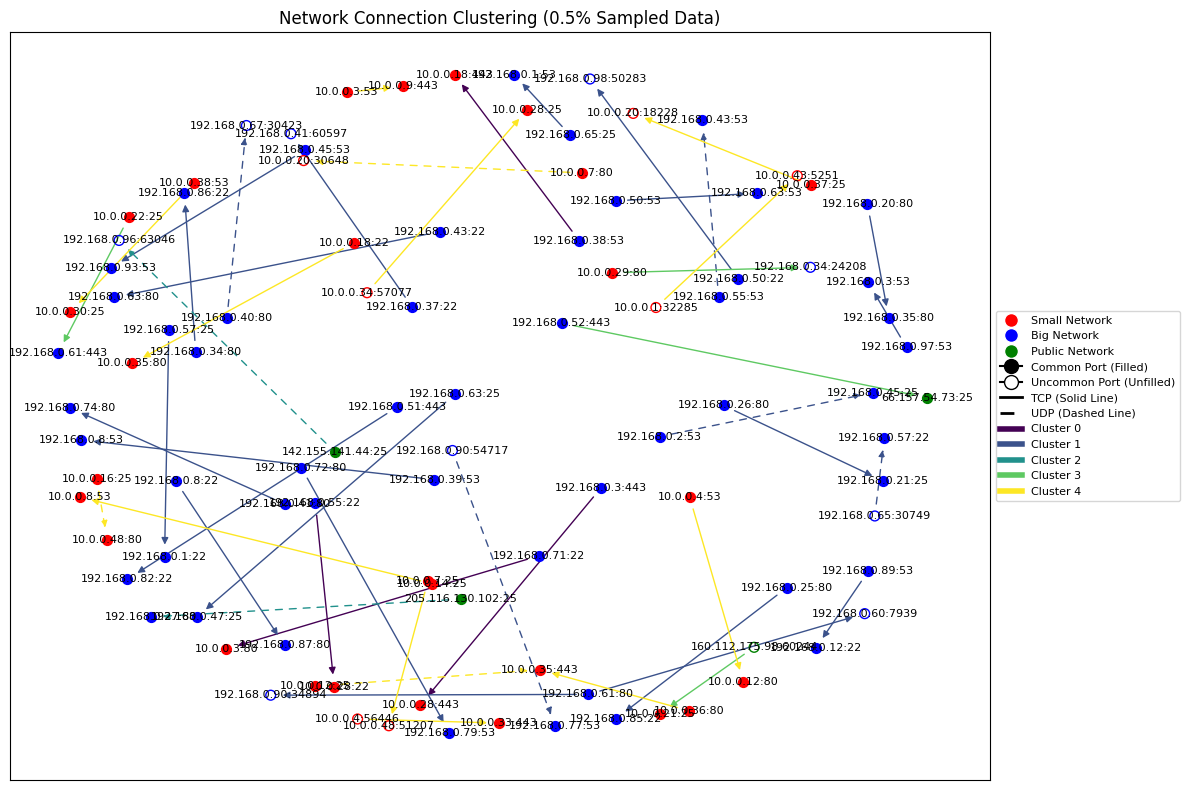

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Define network types based on IP address patterns
def network_type(ip):
    if ip.startswith('10.0.0.'):
        return 'small'
    elif ip.startswith('192.168.0.'):
        return 'big'
    else:
        return 'public'

# Define common ports
COMMON_PORTS = [80, 443, 53, 22, 25]

# Function to sample x% of each cluster
def sample_x_percent(data):
    return data.groupby('AC_cluster', group_keys=False).apply(lambda x: x.sample(frac=0.005))

# Sample x% of data points from each cluster
df_sampled = sample_x_percent(df_sample)

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes and edges from the sampled data to the graph
for idx, row in df_sampled.iterrows():
    src_ip_port = f"{row['src_ip']}:{row['src_port']}"
    dst_ip_port = f"{row['dst_ip']}:{row['dst_port']}"
    protocol = row['protocol']
    cluster = row['AC_cluster']

    # Add an edge from src_ip:src_port to dst_ip:dst_port with the connection attributes
    G.add_edge(src_ip_port, dst_ip_port, protocol=protocol, cluster=cluster)

# Get unique clusters
unique_clusters = df_sampled['AC_cluster'].unique()

# Generate a discrete colormap for clusters using linspace and colormap
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(unique_clusters))]
cluster_to_color = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

# Define node colors based on network type
node_color_map = {
    'small': 'red',    # Small network nodes will be red
    'big': 'blue',     # Big network nodes will be blue
    'public': 'green'  # Public network nodes will be green
}

# Visualize the graph
plt.figure(figsize=(12, 8))

# Get positions of the nodes using a spring layout
pos = nx.spring_layout(G, k=0.5)  # Position nodes using a force-directed layout

# Draw edges with different styles based on the protocol
for edge in G.edges(data=True):
    src, dst = edge[0], edge[1]
    protocol = edge[2]['protocol']
    cluster = edge[2]['cluster']

    # Set the edge color based on the cluster
    edge_color = cluster_to_color[cluster]

    # Set the edge style based on the protocol
    if protocol == 'TCP':
        style = 'solid'  # Solid line for TCP
    else:
        style = (0, (5, 5))  # Dashed line for UDP

    # Draw the edge with the specified style and color
    nx.draw_networkx_edges(G, pos, edgelist=[(src, dst)], edge_color=edge_color, style=style)

# Draw nodes by color based on network type, and fill based on common ports
for node in G.nodes():
    ip, port = node.split(':')
    port = int(port)  # Convert port to integer
    n_type = network_type(ip)
    node_color = node_color_map[n_type]

    # Check if the port is common
    if port in COMMON_PORTS:
        # Common port: Filled node
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=50, node_color=node_color)
    else:
        # Uncommon port: Empty node (only border)
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=50, edgecolors=node_color, node_color='none')

# Add labels for nodes (IP:Port addresses)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

# Custom legend for nodes and edges

# Legend for network types
network_legend = [
    Line2D([0], [0], marker='o', color='w', label='Small Network', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Big Network', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Public Network', markerfacecolor='green', markersize=10)
]

# Legend for common vs uncommon ports (filled vs unfilled nodes)
port_legend = [
    Line2D([0], [0], marker='o', color='black', label='Common Port (Filled)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='black', label='Uncommon Port (Unfilled)', markerfacecolor='w', markersize=10)
]

# Legend for protocol (TCP vs UDP, line styles)
protocol_legend = [
    Line2D([0], [0], color='black', lw=2, label='TCP (Solid Line)', linestyle='solid'),
    Line2D([0], [0], color='black', lw=2, label='UDP (Dashed Line)', linestyle=(0, (5, 5)))
]

# Legend for cluster colors (edge colors)
cluster_legend = [
    Line2D([0], [0], color=colors[i], lw=4, label=f'Cluster {unique_clusters[i]}') for i in range(len(unique_clusters))
]

# Combine all legends
plt.legend(handles=network_legend + port_legend + protocol_legend + cluster_legend,
           loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

plt.title('Network Connection Clustering (0.5% Sampled Data)')
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


In [17]:
for c in unique_clusters:
  print('Cluster', c)
  print(df_sample[df_sample['AC_cluster']==c].iloc[:, 0:4])
  print('\n'*5)

Cluster 0
             src_ip  src_port protocol           dst_ip
2      192.168.0.87        53      TCP        10.0.0.35
18     192.168.0.25        53      TCP        10.0.0.10
22    65.196.223.53        25      TCP     192.168.0.93
29     192.168.0.94        25      TCP        10.0.0.42
41     192.168.0.55        22      TCP        10.0.0.28
...             ...       ...      ...              ...
9920      10.0.0.32     48322      TCP    191.75.183.80
9924   192.168.0.22       443      TCP        10.0.0.42
9943       10.0.0.1        80      TCP  149.185.108.188
9949      10.0.0.25     18939      UDP   95.238.177.212
9962   192.168.0.88        80      TCP        10.0.0.21

[747 rows x 4 columns]






Cluster 1
            src_ip  src_port protocol        dst_ip
0     192.168.0.51     62978      TCP  192.168.0.91
3     192.168.0.88     27857      TCP  192.168.0.34
4     192.168.0.69     25930      UDP  192.168.0.59
6     192.168.0.59        25      TCP  192.168.0.84
7     192.168.0.92